In [9]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device('cuda')
device = torch.device('cpu')



In [45]:
onehot = pd.read_csv('OneHotVectors.csv').fillna(0.0)

In [38]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset

class steamGamesDataset(Dataset):
    def __init__(self, lhs_dataframe, rhs_dataframe, device='cpu'):
        self.lhs_df = lhs_dataframe
        self.rhs_df = rhs_dataframe
        # self.dataset = pd.concat([lhs_dataframe, rhs_dataframe], axis=1)

    def __len__(self):
        return len(self.lhs_df)

    def __getitem__(self, index):
        inp_features = torch.tensor(self.lhs_df.iloc[index]).to(torch.float32)
        value = torch.tensor(self.rhs_df.iloc[index]).to(torch.float32)
        return inp_features, value

In [64]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self,input_size, squeeze_size, device='cpu'):
        super().__init__()


        self.encoder = nn.Sequential(
            nn.Linear(input_size, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
            nn.ReLU(),
            nn.Linear(320, 160))

        self.decoder = nn.Sequential(
            nn.Linear(160, 320),
            nn.ReLU(),
            nn.Linear(320, 640),
            nn.ReLU(),
            nn.Linear(640, 740),
            nn.ReLU(),
            nn.Linear(740, input_size),
            nn.Sigmoid())

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec



In [65]:
autoEncoder_dataset = steamGamesDataset(onehot, onehot)
autoEncoder_dataloader = data.DataLoader(autoEncoder_dataset, batch_size=12024)


In [66]:
model = AutoEncoder(834, 1, device=device).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, weight_decay = 1e-8)


In [69]:
epochs = 1
outputs = []
losses = []
i = 0
for epoch in range(epochs):
  print(f'Epoch: {epoch}', end='\r')
  for (image, output) in autoEncoder_dataloader:
    i += 1
    if i % 10: print(f'itteration: {i}', end='\r')
    image = image.to(device)
    output = output.to(device)
    # Reshaping the image to (-1, 784)
    #   image = image.reshape(-1, 28*28)

    # Output of Autoencoder
    reconstructed = model(image)

    # Calculating the loss function
    loss = loss_function(reconstructed, image)

    # The gradients are set to zero,
    # the gradient is computed and stored.
    # .step() performs parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

		# Storing the losses in a list for plotting
    losses.append(loss.detach())
  # outputs.append((epochs, image, reconstructed))

# # Defining the Plot Style
# plt.style.use('fivethirtyeight')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')

# # Plotting the last 100 values
# plt.plot(losses[-100:])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

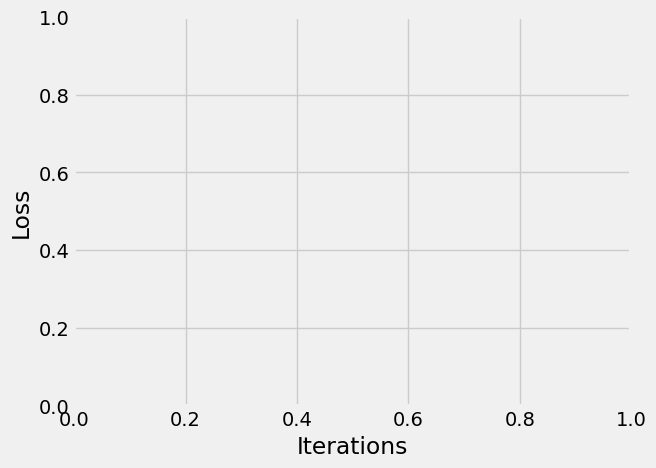

In [70]:
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)

In [73]:
torch.save(model.encoder.state_dict(), '../encoderparams1.pt')

In [79]:
class encoder(nn.Module):
    def __init__(self,input_size, squeeze_size, device='cpu'):
        super().__init__()


        self._encoder = nn.Sequential(
            nn.Linear(input_size, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
            nn.ReLU(),
            nn.Linear(320, 160))

    def forward(self, x):
        enc = self._encoder(x)
        # dec = self.decoder(enc)
        return enc


In [80]:
encoder_model = encoder(834, 1).to(device)
encoder_model._encoder.load_state_dict(torch.load('/encoderparams.pt'))
encoder_model.to(device)

encoder(
  (_encoder): Sequential(
    (0): Linear(in_features=834, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=320, bias=True)
    (3): ReLU()
    (4): Linear(in_features=320, out_features=160, bias=True)
  )
)

In [81]:
encoded = pd.DataFrame()
encoded_list = []
for inp, _ in autoEncoder_dataloader:
    # encoder_model.eval()
    inp = inp.to(device)
    output = encoder_model.forward(inp)
    print(output)
    encoded_list.append(pd.DataFrame(output.detach().cpu().numpy()))
    # encoded = pd.concat([encoded, pd.DataFrame(output.detach().cpu().numpy())])

encoded = pd.concat(encoded_list)


tensor([[ 9.4751e-03, -2.3631e-03, -3.4093e-03,  ...,  1.5877e-02,
          6.4735e-03,  1.2219e-02],
        [ 1.4885e-02,  3.5324e-02,  1.6593e-02,  ..., -1.8814e-02,
          3.5429e-02, -1.2247e-02],
        [ 9.5165e-03,  5.0621e-03, -5.0812e-04,  ...,  2.4769e-02,
          9.6011e-03,  1.7661e-02],
        ...,
        [ 8.8675e-01,  7.4655e+01, -9.7546e+00,  ...,  1.1955e+01,
          5.3752e+01, -3.2640e+01],
        [ 8.7252e-01,  7.4630e+01, -9.7438e+00,  ...,  1.1957e+01,
          5.3747e+01, -3.2615e+01],
        [ 8.8809e-01,  7.4633e+01, -9.7256e+00,  ...,  1.1973e+01,
          5.3761e+01, -3.2616e+01]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[  0.8720,  74.6358,  -9.7593,  ...,  11.9852,  53.7524, -32.6177],
        [  0.8910,  74.6493,  -9.7561,  ...,  11.9567,  53.7622, -32.6433],
        [  0.8382,  74.6637,  -9.7665,  ...,  11.9652,  53.7716, -32.6473],
        ...,
        [  1.7524, 149.2886, -19.5012,  ...,  23.8833, 107.4861, -65.2574],
        

In [82]:
print(encoded)

            0           1          2           3           4          5    \
0      0.009475   -0.002363  -0.003409    0.041208    0.026933  -0.047063   
1      0.014885    0.035324   0.016593    0.032428    0.043128  -0.061682   
2      0.009517    0.005062  -0.000508    0.028606    0.021240  -0.044766   
3      0.011100    0.037920  -0.002507   -0.000321    0.057784  -0.049342   
4      0.013272    0.032456  -0.001102    0.026311    0.022700  -0.064703   
...         ...         ...        ...         ...         ...        ...   
11591  5.265992  445.184296 -58.145466 -111.409401  355.649536 -75.058167   
11592  5.208364  445.205536 -58.152615 -111.442291  355.712585 -75.028030   
11593  5.245724  445.211334 -58.107674 -111.414742  355.687378 -75.073235   
11594  5.255037  445.192749 -58.136223 -111.423149  355.689880 -75.051300   
11595  5.242000  445.199188 -58.114120 -111.426666  355.692169 -75.061447   

             6          7          8          9    ...         150  \
0    

In [83]:
encoded.to_csv('/encoded_oh.csv')

In [10]:
class NN(nn.Module):
    def __init__(self,input_size, device='cpu'):
        super().__init__()


        self.hidden = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(),
            nn.Linear(input_size, input_size),
            nn.ReLU(),
            nn.Linear(input_size, input_size),
            nn.Sigmoid(),
            nn.Linear(input_size, 1))


    def forward(self, x):
        return self.hidden(x)

In [5]:
lhs_df = pd.read_csv('/lhsDataset.csv')

onehot_enc = pd.read_csv('/encoded_oh.csv')


rhs_df = pd.read_csv('/rhs.csv')
rhs_df = rhs_df['Median playtime forever'].to_frame()

lhs_df = pd.concat([lhs_df, onehot_enc], axis=1)

In [7]:
lhs_df = (lhs_df.astype('Float64') - lhs_df.astype('Float64').min()) / (lhs_df.astype('Float64').max() - lhs_df.astype('Float64').min())


In [6]:
lhs_df.shape

(71716, 197)

In [8]:
model = NN(197, device=device).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
gdataset = steamGamesDataset(lhs_df, rhs_df)
gdataloader = data.DataLoader(gdataset, batch_size=1024)

In [ ]:
epochs = 3
outputs = []
losses = []
i = 0
for epoch in range(epochs):
  print(f'Epoch: {epoch}', end='\r')
  for (image, output) in gdataloader:
    i += 1
    if i % 10: print(f'itteration: {i}', end='\r')
    image = image.to(device)
    output = output.to(device)
    # Reshaping the image to (-1, 784)
    #   image = image.reshape(-1, 28*28)

    # Output of Autoencoder
    reconstructed = model.forward(image)

    # Calculating the loss function
    loss = loss_function(reconstructed, image)

    # The gradients are set to zero,
    # the gradient is computed and stored.
    # .step() performs parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

		# Storing the losses in a list for plotting
    losses.append(loss.detach().cpu())
    # print(loss._item)
  # outputs.append((epochs, image, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)

In [122]:
def test_model(model, criterion, tuple_model_output=False, n_to_show=1):
    test_loss = 0.0
    show_predictions = []
    show_gt = []
    i = 0
    for input, label in gdataloader:
        input = input.to(torch.float64).to(device)
        label = label.to(torch.float64).to(device)

        # input = nn.functional.normalize(input)
        # label = nn.functional.normalize(label)

        print(input)

        prediction = model.forward(input)

        if i < n_to_show:
            show_predictions.append(input)
            show_gt.append(label.detach().cpu().numpy())

        i += 1

        loss = criterion(prediction, label)
        test_loss += loss
    test_loss = test_loss / dataset_sizes['test']

    # line_types = [':', '--', '-.']
    # for idx, input in enumerate(show_predictions):
    #     if tuple_model_output:
    #         pred, hn = model(input)
    #         print(f'Hidden {idx}: {hn}')
    #     else:
    #         pred = model(input)
    #     print(f'Input {idx}: {input}')
    #     print(f'Prediction {idx}: {pred}')

    #     plt.plot(pred.detach().cpu().numpy(), ':', label='prediction_'+str(idx))
    # for idx, gt in enumerate(show_gt):
    #     plt.plot(1,  gt, label='GT_'+str(idx))
    # plt.legend()
    print(f'Test Loss: {test_loss}')


In [123]:
test_model(model=NN, criterion=loss_function)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.5877e-02,
          6.4735e-03,  1.2219e-02],
        [ 1.0000e+00,  1.0000e+00,  0.0000e+00,  ..., -1.8814e-02,
          3.5429e-02, -1.2247e-02],
        [ 2.0000e+00,  2.0000e+00,  0.0000e+00,  ...,  2.4769e-02,
          9.6011e-03,  1.7661e-02],
        ...,
        [ 1.0210e+03,  1.0210e+03,  0.0000e+00,  ...,  1.0550e+00,
          4.5436e+00, -2.7851e+00],
        [ 1.0220e+03,  1.0220e+03,  0.0000e+00,  ...,  1.0343e+00,
          4.5821e+00, -2.7850e+00],
        [ 1.0230e+03,  1.0230e+03,  0.0000e+00,  ...,  1.0459e+00,
          4.5766e+00, -2.7618e+00]], device='cuda:0', dtype=torch.float64)


TypeError: NN.forward() missing 1 required positional argument: 'x'

In [133]:
losses = []
for (image, output) in gdataloader:
    if i > 10000:
        break
    i += 1
    if i % 10: print(f'itteration: {i}', end='\r')
    image = image.to(device)
    output = output.to(device)
    # Reshaping the image to (-1, 784)
    #   image = image.reshape(-1, 28*28)

    # Output of Autoencoder
    reconstructed = model.forward(image)

    # Calculating the loss function
    loss = loss_function(reconstructed, image)

		# Storing the losses in a list for plotting
    losses.append(loss.detach().cpu())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 197])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 197])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [134]:
print(sum(losses)/len(losses))

tensor(32635266.)
